# Joint model for cascades

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
from joint_model_cascades import * 

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Forward model

Given a set of $K$ sources with known redshifts $z_k$, positions $\varpi_k$ and uniform luminosities $L$, simulate a neutrino data set. 

The neutrinos are produced at the source with spectrum ${\rm{d}}N/{\rm{d}}\tilde{E} \propto \tilde{E}^{-\alpha}$, they lose energy according to adiabatic expansion such that $\tilde{E} = (1+z)E$ and are detected with a simple uncertainty $\sigma_E$.

In [2]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
unit_vector = [p / np.linalg.norm(p) for p in position]
    
# Use simple Aeff calculated in `arrival_direction_model/testing_simple_model.ipynb`.
# Just for testing, to be replaced with a better solution...
filename = 'data/IC79-2010-TabulatedAeff.txt'
effective_area = IceCubeAeff(filename, selected_E = 1E5) # GeV

# Exposure factor for sources in catalog
T = 1 # yr
eps = [] # m^2 yr

# Sources
for uv in unit_vector:
    zenith_angle = np.pi - np.arccos(uv[2])
    mk = effective_area.m(zenith_angle)
    eps.append(effective_area._Aeff_max * T * mk)   

# Isotropic background
eps.append(effective_area._Aeff_max * T * (effective_area.M / (4*np.pi)))

# Interpolation grid
zenith_grid = np.linspace(0, np.pi)
m_grid = [effective_area.m(z) for z in zenith_grid]

In [3]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim.stan', 
                                 model_name = 'nu_sim', include_paths = 'stan/')

Using cached StanModel


In [4]:
# Prepare simulation inputs
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
dl = [luminosity_distance(z) for z in redshift] # Mpc
sim_input['D'] = dl # Mpc
sim_input['varpi'] = unit_vector

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 100 # TeV
sim_input['sigmaE'] = 10 # TeV

# Deflection
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction 
total_flux = 4.0 # m^-2 yr^-1
f = 0.5

Q = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) for d in dl])) ) # yr^-1
F0 = (1 - f) * total_flux # m^-2 yr^-1

sim_input['Q'] = Q # yr^-1
sim_input['F0'] = F0 # m^-2 yr^-1

# Exposure
sim_input['eps'] = eps
sim_input['Ngrid'] = len(zenith_grid)
sim_input['zenith_grid'] = zenith_grid
sim_input['m_grid'] = m_grid

In [5]:
# Simulate
simulation = sim.sampling(data = sim_input, iter =1, chains = 1, 
                          algorithm = "Fixed_param")

In [6]:
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
era = event.d.icrs.ra.rad
edec = event.d.icrs.dec.rad

/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


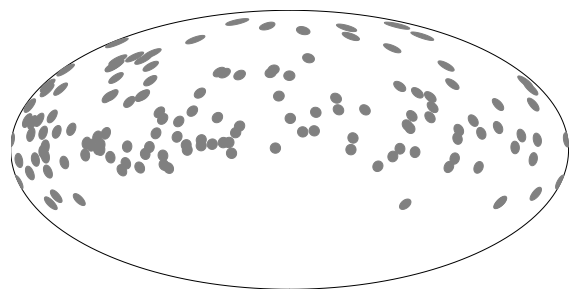

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
for er, ed in zip(era, edec):
    skymap.tissot(np.rad2deg(er), np.rad2deg(ed), 3, 30, color = 'grey')